# Pytorch
Installation: https://pytorch.org/get-started/locally/

Documentation: https://pytorch.org/docs/stable/index.html

In [491]:
import sys
print(f'Using python version {sys.version}') # get python version

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

Using python version 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]


# Downloading data:

# Loading and examining data

In [492]:
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
X_test_np = np.load("X_test.npy")
y_test_np = np.load("y_test.npy")

In [493]:
print (f'Training/Valid data shape: {X_train_valid.shape}')
print (f'Training/Valid labels shape: {y_train_valid.shape}')
print (f'Test data shape: {X_test_np.shape}')
print (f'Test labels shape: {y_test_np.shape}')

Training/Valid data shape: (2115, 22, 1000)
Training/Valid labels shape: (2115,)
Test data shape: (443, 22, 1000)
Test labels shape: (443,)


Text(0, 0.5, 'count')

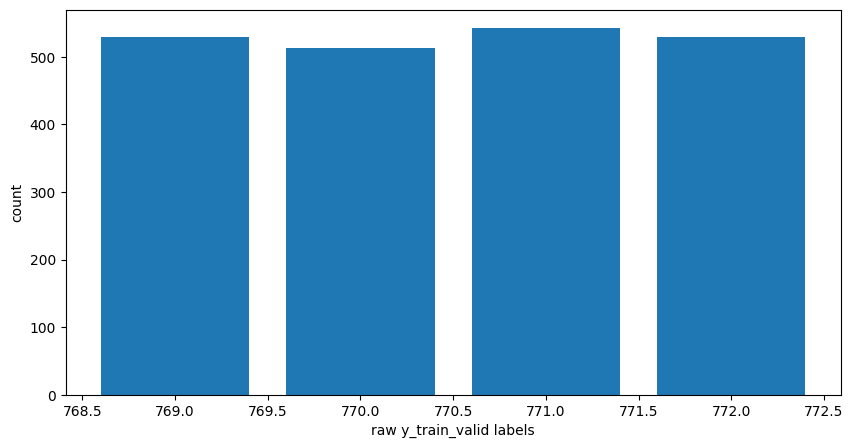

In [494]:
plt.figure(figsize=(10, 5))
plt.bar(*np.unique(y_train_valid, return_counts=True))
plt.xlabel('raw y_train_valid labels')
plt.ylabel('count')

In [495]:
# Convert to 0-4 labeling and integer type (integers needed for categorical labels)
y_train_valid = (y_train_valid - np.min(y_train_valid)).astype('int')
y_test_np = (y_test_np - np.min(y_test_np)).astype('int')

# Modules

In [496]:
# inherits from nn.Module
class ShallowConvNet(nn.Module):
    def __init__(self, input_shape=(22, 1000), n_temporal_filters=40, n_spatial_filters=40, n_classes=4):
        super().__init__() # call __init__ method of superclass
        
        self.input_shape = input_shape # last two dimensions, (excluding batch size). Should be length 2.
        self.n_temporal_filters = n_temporal_filters
        self.n_spatial_filters = n_spatial_filters
        self.n_classes = n_classes

        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        self.temporal_convolution = nn.Conv2d(1, n_temporal_filters, (1, 25))

        # We could implement the spatial convolution as a 1d, or 2d, or 3d convolution.
        # We use 2d here.
        self.spatial_convolution = nn.Conv2d(n_temporal_filters, n_spatial_filters, (input_shape[0], 1))

        self.average_pool = nn.AvgPool2d((1, 75), stride=(1, 15))

        # Final linear layer
        self.n_dense_features = n_spatial_filters*(1 + ((input_shape[1] - 25 + 1) - 75) // 15)
        self.dense = nn.Linear(self.n_dense_features, n_classes)
        # you can also use 'self.dense = nn.LazyLinear(n_classes)' to avoid having to manually compute features

        self.elu = nn.ELU()
        return
    
    # declaring a forward method also makes the instance a callable.
    # e.g.:
    # model = ShallowConvNet()
    # out = model(x)
    def forward(self, x):
        # x has shape (batch_size, input_shape[0], input_shape[1])
        # Let H0 = input_shape[0], H1 = input_shape[1]
        h = x

        # note that h.view(-1, 1, h.shape[1], h.shape[2]) works normally but does not work with torchinfo
        # this is because the torchinfo input has a weird shape
        h = h.view(-1, 1, self.input_shape[0], self.input_shape[1]) # view as (batch_size, 1, input_shape[0], input_shape[1])
        # Sometimes, view doesn't work and you have to use reshape. This is because of how tensors are stored in memory.

        # 2d convolution takes inputs of shape (batch_size, num_channels, H, W)
        h = self.temporal_convolution(h) # (batch_size, 1, H0, W0) -> (batch_size, n_temporal_filters, H0, W0 - 25 + 1)
        h = self.elu(h)

        h = self.spatial_convolution(h) # (batch_size, n_temporal_filters, H0, W0 - 25 + 1) -> (batch_size, n_spatial_filters, 1, W0 - 25 + 1)
        h = self.elu(h)

        h = h**2 # square
        # alternatively, use torch.pow(h, 2.0)

        h = self.average_pool(h) # (batch_size, n_spatial_filters, 1, W0 - 25 + 1) -> (batch_size, n_spatial_filters, 1, 1 + ((W0 - 25 + 1) - 75)//15)

        h = torch.log(h) # (natural) log

        h = h.view(h.shape[0], -1) # flatten the non-batch dimensions
        h = self.dense(h) # (batch_size, self.n_dense_features) -> (batch_size, n_classes)

        return h



# Summarizing modules

In [497]:
from torchinfo import summary
# Only uses outputs of modules.
print(summary(ShallowConvNet(), input_size=(22, 1000)))

Layer (type:depth-idx)                   Output Shape              Param #
ShallowConvNet                           [1, 4]                    --
├─Conv2d: 1-1                            [1, 40, 22, 976]          1,040
├─ELU: 1-2                               [1, 40, 22, 976]          --
├─Conv2d: 1-3                            [1, 40, 1, 976]           35,240
├─ELU: 1-4                               [1, 40, 1, 976]           --
├─AvgPool2d: 1-5                         [1, 40, 1, 61]            --
├─Linear: 1-6                            [1, 4]                    9,764
Total params: 46,044
Trainable params: 46,044
Non-trainable params: 0
Total mult-adds (M): 56.73
Input size (MB): 0.09
Forward/backward pass size (MB): 7.18
Params size (MB): 0.18
Estimated Total Size (MB): 7.46


# Using GPUs with pytorch

In [498]:
# See https://pytorch.org/docs/stable/notes/cuda.html
print(torch.cuda.is_available())
device_id = 0 if torch.cuda.is_available() else 'cpu' # Equivalent to device_id = 'cuda:0'
# device_id =  'cpu' # Equivalent to device_id = 'cuda:0'
device = torch.device(device_id) # use these semantics to specify a specific device. 

True


In [499]:
print(torch.zeros(4).cuda().device)
print(torch.zeros(4).to(device).device)
print(torch.zeros(4).to('cpu').device)

cuda:0
cuda:0
cpu


# Creating a dataset and dataloader

In [500]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=12345)

t_start = 0
t_end = 400
t_step = 1
t_size = int(np.ceil((t_end - t_start) / t_step))
n_crops = 5
t_crop = 50
X_train_np = np.vstack([X_train_np[:, :, t_start+i*t_crop:t_end+i*t_crop:t_step] for i in np.arange(n_crops)])
# X_train_np = np.vstack((
#     X_train_np[:, :, t_start+0:t_end+0:t_step],
#     X_train_np[:, :, t_start+1:t_end+1:t_step],
#     X_train_np[:, :, t_start+2:t_end+2:t_step],
#     X_train_np[:, :, t_start+3:t_end+3:t_step],
#     nn.MaxPool1d(t_step).forward(torch.from_numpy(X_train_np[:, :, t_start:t_end]).to(device)).cpu().numpy(),
#     nn.AvgPool1d(t_step).forward(torch.from_numpy(X_train_np[:, :, t_start:t_end]).to(device)).cpu().numpy() + np.random.normal(0, 0.5, (len(X_train_np), 22, t_size))
# ))
y_train_np = np.hstack([y_train_np for _ in np.arange(n_crops)])
# X_val_np = X_val_np[:, :, t_start:t_end:t_step]

X_mean = np.mean(X_train_np, axis=2)
X_val_mean = np.mean(X_val_np, axis=2)

# X_train_np -= X_mean[:, :, np.newaxis]
# X_val_np -= X_val_mean[:, :, np.newaxis]

# X_train = torch.FloatTensor(new_X_train).to(device)
X_train = torch.FloatTensor(X_train_np).to(device)
X_val = torch.FloatTensor(X_val_np).to(device)
X_test = torch.FloatTensor(X_test_np).to(device)
# y_train = torch.LongTensor(new_y_train).to(device)
y_train = torch.LongTensor(y_train_np).to(device)
y_val = torch.LongTensor(y_val_np).to(device)
y_test = torch.LongTensor(y_test_np).to(device)

In [501]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        if isinstance(X, np.ndarray):
            self.X = torch.FloatTensor(X) # 32-bit float
        else:
            self.X = X
        if isinstance(Y, np.ndarray):
            self.Y = torch.LongTensor(Y) # integer type
        else:
            self.Y = Y
        return
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [502]:
batch_size = 64
train_dataset = MyDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = MyDataset(X_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = MyDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)


In [503]:
len(train_dataset), len(train_dataloader)

(8460, 133)

# Training a model

In [504]:
import tqdm # for progress bar

# Saving models

#RNN

In [505]:
class AlexNet(nn.Module):
    def __init__(self, input_dim=22, output_dim=4):
        super(AlexNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.f1 = nn.Linear(input_dim, 128)
        self.elu = nn.ELU()

        self.c2 = nn.Conv1d(128, 64, 3)

        self.p2 = nn.MaxPool1d(2)
        self.d2 = nn.Dropout(0.5)

        self.r3 = nn.LSTM(64, 32, batch_first=True, num_layers=1)
        self.f4 = nn.Linear(32, output_dim)

    def forward(self, x, h_0=None):
        # x has shape (batch_size, input_dim, timesteps)
        # h_0 has shape (D*num_layers, hidden_dim)

        # print(x.shape)
        # print(x.shape)

        x = x.permute(0, 2, 1) # (batch_size, input_dim, timesteps) -> (batch_size, timesteps, input_dim)
        x = self.f1(x)
        x = self.elu(x)
        x = x.permute(0, 2, 1) # (batch_size, timesteps, input_dim) -> (batch_size, input_dim, timesteps)

        x = self.c2(x)
        x = self.elu(x)
        x = self.p2(x)
        x = self.d2(x)

        x = x.permute(0, 2, 1) # (batch_size, input_dim, timesteps) -> (batch_size, timesteps, input_dim)
        
        if h_0 is None:
            x, hn = self.r3(x) # (batch_size, timesteps, input_dim) -> (batch_size, timesteps, hidden_dim)
        else:
            # We detach h_0 (not required, just recommended) so that the computational graph does not extend too far.
            x, hn = self.r3(x, h_0) # (batch_size, timesteps, input_dim) -> (batch_size, timesteps, hidden_dim)
        # hn is the stored hidden state after computation
        x = self.f4(x[:, -1, :])
        # x = self.elu(x)
        # x = self.dropout(x)
        # x = self.fc3(x)
        return x

In [506]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim=22, hidden_dim=64, output_dim=4):
        super(RNNClassifier, self).__init__()
        self.a1 = nn.AvgPool1d(4)
        self.d = nn.Dropout1d(0.25)
        self.conv1 = nn.Conv1d(input_dim, 32, 2, padding='same')
        self.h1 = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, 2, padding='same')
        self.h2 = nn.ReLU()
        self.conv3 = nn.Conv1d(64, 128, 2, padding='same')
        self.h3 = nn.ReLU()
        self.fc1 = nn.Linear(128, 98)
        self.h4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.rnn = nn.LSTM(98, hidden_dim, batch_first=True, num_layers=1)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x, h_0=None):
        x = self.a1(x)
        x = x.permute(0, 2, 1) # (batch_size, input_dim, timesteps) -> (batch_size, timesteps, input_dim)
        x = self.d(x)
        x = x.permute(0, 2, 1) # (batch_size, input_dim, timesteps) -> (batch_size, timesteps, input_dim)
        x = self.conv1(x)
        x = self.h1(x)
        x = self.conv2(x)
        x = self.h2(x)
        x = self.conv3(x)
        x = self.h3(x)
        x = x.permute(0, 2, 1) # (batch_size, input_dim, timesteps) -> (batch_size, timesteps, input_dim)       
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.h4(x)
        if h_0 is None:
            x, hn = self.rnn(x) # (batch_size, timesteps, input_dim) -> (batch_size, timesteps, hidden_dim)
        else:
            x, hn = self.rnn(x, h_0) # (batch_size, timesteps, input_dim) -> (batch_size, timesteps, hidden_dim)
        return self.fc2(x[:, -1, :])

In [507]:
# Positional Encoding example from the torch transformer tutorial:
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=22, output_dim=4):
        super(TransformerClassifier, self).__init__()
        self.c1 = nn.Conv1d(input_dim, 32, 2, padding='same')
        self.h1 = nn.ReLU()
        self.d1 = nn.Dropout(0.5)
        self.c2 = nn.Conv1d(32, 64, 2, padding='same')
        self.h2 = nn.ReLU()

        self.p3 = PositionalEncoding(64, 0.5, 100)
        encoder = nn.TransformerEncoderLayer(64, nhead=4, dim_feedforward=1024, dropout=0.2, batch_first=True)
        norm = nn.LayerNorm(64)
        self.t3 = nn.TransformerEncoder(encoder, 2, norm)

        self.fl4 = nn.Flatten()
        self.f4 = nn.LazyLinear(output_dim)
    
    def forward(self, x):
        x = self.c1(x)
        x = self.h1(x)
        x = self.d1(x)
        x = self.c2(x)
        x = self.h2(x)

        x = x.permute(0, 2, 1)
        x = self.p3(x)
        x = self.t3(x)

        x = self.fl4(x)
        x = self.f4(x)
        return x

In [508]:
# Note that sometimes RNNs run faster on cpu, but usually only if they're small.
#device = torch.device('cpu')

model = RNNClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
celoss = nn.CrossEntropyLoss()

loss_hist = []
val_loss_hist = []
acc_hist = []
val_acc_hist = []

In [509]:
from torchinfo import summary
print(summary(model, input_size=(22, t_size), batch_dim=0))


Layer (type:depth-idx)                   Output Shape              Param #
RNNClassifier                            [1, 4]                    --
├─AvgPool1d: 1-1                         [1, 22, 100]              --
├─Dropout1d: 1-2                         [1, 100, 22]              --
├─Conv1d: 1-3                            [1, 32, 100]              1,440
├─ReLU: 1-4                              [1, 32, 100]              --
├─Conv1d: 1-5                            [1, 64, 100]              4,160
├─ReLU: 1-6                              [1, 64, 100]              --
├─Conv1d: 1-7                            [1, 128, 100]             16,512
├─ReLU: 1-8                              [1, 128, 100]             --
├─Linear: 1-9                            [1, 100, 98]              12,642
├─Dropout: 1-10                          [1, 100, 98]              --
├─ReLU: 1-11                             [1, 100, 98]              --
├─LSTM: 1-12                             [1, 100, 64]              41,9

In [510]:
num_epochs = 200

# progress bar
pbar = tqdm.tqdm(
    range(num_epochs), position=0, leave=True,
    bar_format='{l_bar}{bar:30}{r_bar}',
)
for epoch in pbar:
    model.train() # set model to training mode.
    for batch in train_dataloader:
        optimizer.zero_grad() # clear gradients of parameters that optimizer is optimizing
        x, y = batch

        # x = x.to(device) # necessary if X is not on the same device as model
        # y = y.to(device)

        out = model(x) # shape (batch_size, n_classes)
        loss = celoss(out, y) # calculate the cross entropy loss

        loss.backward() # backpropagate
        optimizer.step() # perform optimization step
    
    model.eval() # set model to evaluation mode.
    # calculate accuracy for training and validation sets
    ns = 0 # number of samples
    nc = 0 # number of correct outputs
    loss_acc = 0
    with torch.no_grad():
        for batch in train_dataloader:
            x, y = batch
            out = model(x)
            loss = celoss(out, y)
            loss_acc += loss.item() * len(y)
            ns += len(y)
            nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
    loss_hist.append(loss_acc / ns)
    acc_hist.append(nc/ns)

    ns = 0 # number of samples
    nc = 0 # number of correct outputs
    loss_acc = 0
    with torch.no_grad():
        for batch in val_dataloader:
            x, y = batch
            outs = torch.from_numpy(
                np.array(
                    [model(x[:, :, t_start+i*t_crop:t_end+i*t_crop:t_step]).cpu().numpy() for i in np.arange(n_crops)]
                    # + [model(nn.MaxPool1d(t_step)(x[:, :, t_start:t_end])).cpu().numpy()]
                    # + [model(nn.AvgPool1d(t_step)(x[:, :, t_start:t_end]) + torch.FloatTensor(np.random.normal(0, 0.5, (len(x), 22, t_size))).to(device)).cpu().numpy()]
                )
            ).to(device)
            out = torch.mean(outs, axis=0)
            loss = celoss(out, y)
            loss_acc += loss.item() * len(y)
            ns += len(y)
            nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
    val_loss_hist.append(loss_acc / ns)
    val_acc_hist.append(nc/ns)


    # update progress bar postfix
    pbar.set_postfix({'acc': acc_hist[-1], 'val_acc': val_acc_hist[-1]})

100%|██████████████████████████████| 200/200 [03:53<00:00,  1.17s/it, acc=0.899, val_acc=0.619]


In [517]:
# Compute test accuracy
if True:
    model.eval() # set model to evaluation mode.
    ns = 0 # number of samples
    nc = 0 # number of correct outputs
    with torch.no_grad():
        for batch in test_dataloader:
            x, y = batch
            outs = torch.from_numpy(
                np.array(
                    [model(x[:, :, t_start+i*t_crop:t_end+i*t_crop:t_step]).cpu().numpy() for i in np.arange(n_crops)]
                    # + [model(nn.MaxPool1d(t_step)(x[:, :, t_start:t_end])).cpu().numpy()]
                    # + [model(nn.AvgPool1d(t_step)(x[:, :, t_start:t_end]) + torch.FloatTensor(np.random.normal(0, 0.5, (len(x), 22, t_size))).to(device)).cpu().numpy()]
                )
            ).to(device)
            out = torch.mean(outs, axis=0)
            ns += len(y)
            nc += (out.max(1)[1] == y).detach().cpu().numpy().sum()
    print(f"Test Accuracy: {nc / ns:.3f}")

Test Accuracy: 0.596


In [512]:
# Best to use .pt for file extensions
# I used to think .pth was used, but it turns out it can have potential conflicts with python
#   (See https://stackoverflow.com/questions/59095824/what-is-the-difference-between-pt-pth-and-pwf-extentions-in-pytorch)

# Save only the model weights
i = 9
i += 1
torch.save(model.state_dict(), f'rnn_{i}_weightsonly.pt')

# Save an entire checkpoint
checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'loss_hist': loss_hist,
    'acc_hist': acc_hist,
    'val_loss_hist': val_loss_hist,
    'val_acc_hist': val_acc_hist,
}
torch.save(checkpoint, f'rnn_{i}_checkpoint.pt')

In [513]:
# chkpt = torch.load(f'rnn_1_checkpoint.pt')
# loss_hist = chkpt['loss_hist']
# acc_hist = chkpt['acc_hist']
# val_loss_hist = chkpt['val_loss_hist']
# val_acc_hist = chkpt['val_acc_hist']

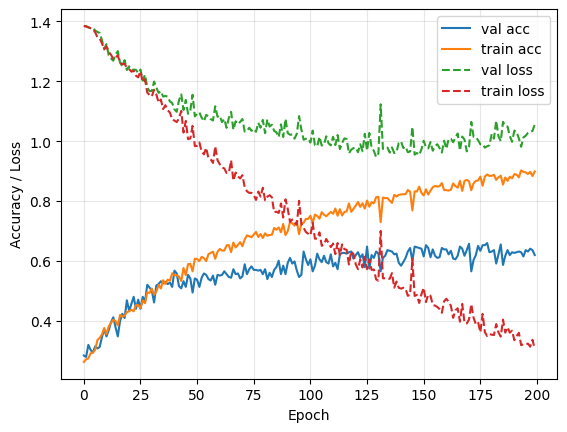

In [514]:
plt.plot(np.arange(len(val_acc_hist)), val_acc_hist, label='val acc')
plt.plot(np.arange(len(acc_hist)), acc_hist, label='train acc')
plt.plot(np.arange(len(val_loss_hist)), val_loss_hist, linestyle='--', label='val loss')
plt.plot(np.arange(len(loss_hist)), loss_hist, linestyle='--', label='train loss')
plt.ylabel('Accuracy / Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

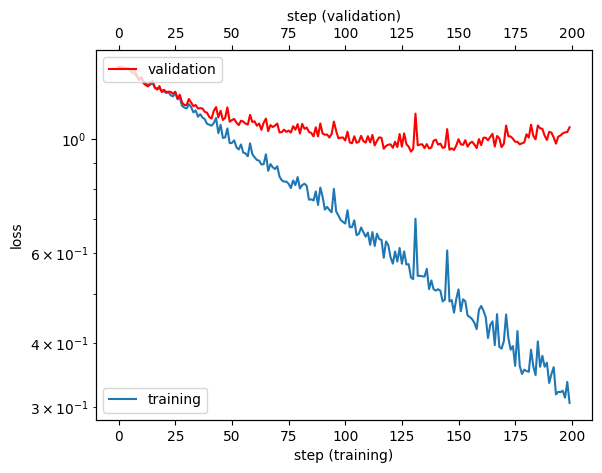

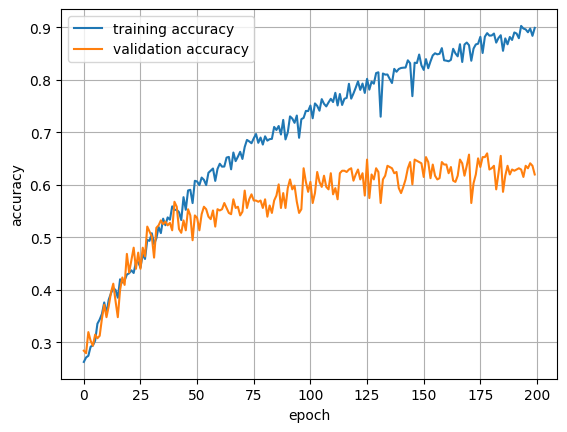

In [515]:
plt.figure(dpi=100)
plt.plot(loss_hist, label='training')
plt.yscale('log')
plt.ylabel('loss')
plt.legend(loc='lower left')
plt.xlabel('step (training)')
plt.twiny()
plt.plot(val_loss_hist, 'r', label='validation')
plt.xlabel('step (validation)')
plt.legend(loc='upper left')
plt.figure(dpi=100)
plt.plot(acc_hist)
plt.plot(val_acc_hist)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])
plt.grid()